# Download the data from OpenReview

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt

import requests
import time

In [2]:
%%time

# Download titles/abstracts/authors of all papers (this part is fast)

# Note: this cell was edited in Jan 2026 to avoid the RateLimitError

titles = []
abstracts = []
years = []
forum_ids = []
decisions = []
authors = []
keywords = []

for year in [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    print(year, end=': ')
    for query in ['submission', 'Submission', 'Blind_Submission', 
                  'Withdrawn_Submission', 'Rejected_Submission', 
                  'Desk_Rejected_Submission', '']:
        if year <= 2017:
            if query == '':
                continue
            url = f'https://api.openreview.net/notes?invitation=ICLR.cc%2F{year}%2Fconference%2F-%2F{query}'
        elif year <= 2023:
            if query == '':
                continue
            url = f'https://api.openreview.net/notes?invitation=ICLR.cc%2F{year}%2FConference%2F-%2F{query}'
        else:
            if query != '':
                query = '/' + query
            url = f'https://api2.openreview.net/notes?content.venueid=ICLR.cc/{year}/Conference{query}'        
            
        for offset in range(0, 10_000, 1000):
            json = requests.get(url + f'&offset={offset}').json()
            
            if 'name' in json and json['name'] == 'RateLimitError':
                time.sleep(30)
                json = requests.get(url + f'&offset={offset}').json()
                
            df = pd.DataFrame(json['notes'])
            if len(df) > 0:
                print(len(df), end=' ')
                if year < 2024:
                    titles    += [d['title'].strip() for d in df['content'].values]
                    abstracts += [d['abstract'].strip() for d in df['content'].values]
                    keywords  += [d['keywords'] for d in df['content'].values]
                    authors   += [', '.join(d['authors']) for d in df['content']]
                else:
                    titles    += [d['title']['value'].strip() for d in df['content'].values]
                    abstracts += [d['abstract']['value'].strip() for d in df['content'].values]
                    keywords  += [d['keywords']['value'] for d in df['content'].values]
                    if 'authors' in df['content'].values[0]:
                        authors   += [', '.join(d['authors']['value']) for d in df['content'].values]
                    else:
                        authors += [''] * len(df)
                years     += [year] * len(df)
                forum_ids += list(df.forum)
                                                
                if 'Withdrawn_Submission' in query:
                    decisions += ['Withdrawn'] * len(df)
                elif 'Desk_Rejected_Submission' in query:
                    decisions += ['Desk rejected'] * len(df)
                elif 'Rejected_Submission' in query:
                    decisions += ['Reject'] * len(df)    
                else:
                    decisions += [''] * len(df)
            else:
                break
    print('')
print('')

print(f'Found {len(titles)} papers\n')

2017: 490 
2018: 935 83 
2019: 1000 419 160 
2020: 1000 1000 213 369 12 
2021: 1000 1000 594 403 17 
2022: 1000 1000 617 779 26 
2023: 1000 1000 1000 792 1000 145 18 
2024: 1000 659 1000 1000 1000 432 53 1000 1000 260 

Found 24476 papers

CPU times: user 6.51 s, sys: 268 ms, total: 6.78 s
Wall time: 2min 1s


In [3]:
iclr = pd.DataFrame.from_dict({
    'year': np.array(years).astype(int), 
    'id': forum_ids, 
    'title': titles, 
    'abstract': abstracts,
    'authors': authors,
    'decision': decisions,
    'scores': [[]] * len(abstracts),
    'keywords': [[kk.lower() for kk in k] for k in keywords],
})

n_submissions = [np.sum(iclr.year == y) for y in np.arange(2017, 2025)]
print('Submisions per year:', n_submissions, '\n')

# Kicking out nonsense abstracts

mask = np.array([len(a) >= 100 for a in iclr.abstract])

print(f'Removing {np.sum(~mask)} submissions with abstract length below 100 characters:')
for abstract in iclr[~mask]['abstract'].values:
    print('  ' + abstract)    
iclr = iclr[mask].reset_index(drop=True)

iclr.to_parquet('../data/iclr24v2.parquet')

Submisions per year: [490, 1013, 1579, 2594, 3014, 3422, 4955, 7404] 

Removing 26 submissions with abstract length below 100 characters:
  
  withdrawn
  abstract
  withdraw
  Paper was withdrawn.
  Placeholder
  withdrawn paper
  NA
  withdrawn
  NA
  N/A
  N/A
  NA
  NA
  NA
  N/A
  NA
  place holder
  Withdraw
  BLANK
  Blank
  Paper withdrawn.
  we have withdrawn our paper.
  test
  xxx
  test


[489, 1007, 1569, 2593, 3009, 3422, 4955, 7401]


<IPython.core.display.Javascript object>


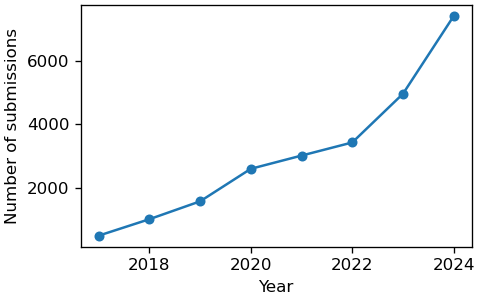

In [4]:
# Sanity check

years = np.arange(2017, 2025)
n_submissions = [np.sum(iclr.year == y) for y in years]
print(n_submissions)

plt.figure(figsize=(4, 2.5), layout='constrained')
plt.plot(years, n_submissions, '.-', markersize=10, clip_on=False)
plt.xlabel('Year')
plt.ylabel('Number of submissions');

<IPython.core.display.Javascript object>


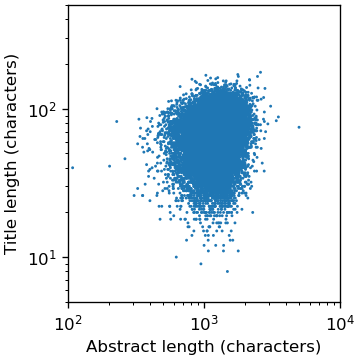

In [6]:
# Sanity check

fig, ax = plt.subplots(figsize=(3, 3), layout='constrained')

len_abstract = [len(a) for a in iclr.abstract]
len_title =    [len(t) for t in iclr.title]

ax.scatter(len_abstract, len_title, s=3, ec='none')
ax.set_xlabel('Abstract length (characters)')
ax.set_ylabel('Title length (characters)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([100, 10000])
ax.set_ylim([5, 500]);

In [7]:
%%time

# Query the accept/reject decisions and scores. Warning: TAKES MANY HOURS
# API cuts you off every 60 queries, then the code sleeps for 30 seconds

for num, forum_id in enumerate(iclr.id):
    if (num + 1) % 1000 == 0:
        print('*', end='')
    elif (num + 1) % 100 == 0:
        print('.', end='')

    year = iclr.year[num]
    
    if year < 2024:
        forum_url = f'https://api.openreview.net/notes?forum={forum_id}'
    else:
        forum_url = f'https://api2.openreview.net/notes?forum={forum_id}'
        
    json = requests.get(forum_url).json()
    
    if 'name' in json and json['name'] == 'RateLimitError':
        time.sleep(30)
        json = requests.get(forum_url).json()

    if iclr.decision[num] == '':
        found_decision = False
        for i in range(len(json['notes'])):
            if 'decision' in json['notes'][i]['content']:
                decision = json['notes'][i]['content']['decision']
                if year >= 2024:
                    decision = decision['value']
                found_decision = True
                break
            elif 'recommendation' in json['notes'][i]['content']:
                decision = json['notes'][i]['content']['recommendation']
                found_decision = True
                break
            # For ICLR 2017
            elif 'withdrawal' in json['notes'][i]['content']:
                if json['notes'][i]['content']['withdrawal'] == 'Confirmed':
                    decision = 'Withdrawn'
                    found_decision = True
                    break
        if found_decision:
            iclr.at[num, 'decision'] = decision
        else:
            print(f'No decision found: {num}, {forum_id}')
        
    scores = []
    for i in range(len(json['notes'])):
        if ((year < 2023) and (year != 2022)) or (year >= 2024):
            score_field = 'rating'
        else:
            score_field = 'recommendation'
        if score_field in json['notes'][i]['content']:
            if year < 2024:
                score = int(json['notes'][i]['content'][score_field].split(':')[0])
            else:
                score = int(json['notes'][i]['content'][score_field]['value'].split(':')[0])
            scores.append(score)
    iclr.at[num, 'scores'] = scores

print('')

# Sort alphabetically by id within year
iclr = iclr.sort_values(by=['year', 'id']).reset_index(drop=True)

iclr.to_parquet('../data/iclr24v2.parquet')

.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*.........*....
CPU times: user 14min 44s, sys: 28.4 s, total: 15min 13s
Wall time: 9h 2min 59s


<IPython.core.display.Javascript object>


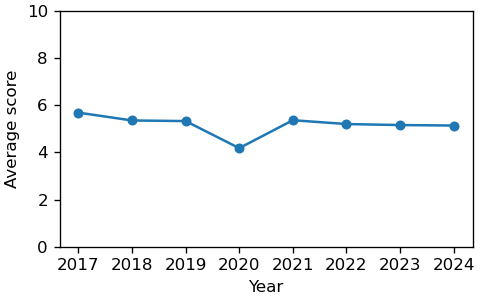

In [15]:
# Sanity check

years = np.arange(2017, 2025)

av_score = [
    np.nanmean(
        [
            np.mean(ss) for ss in iclr[iclr.year==y].scores.values if len(ss) > 0
        ]
    ) for y in years
]

plt.figure(figsize=(4, 2.5), layout='constrained')
plt.plot(years, av_score, '.-', markersize=10, clip_on=False)
plt.xlabel('Year')
plt.ylabel('Average score')
plt.ylim([0, 10]);

<IPython.core.display.Javascript object>


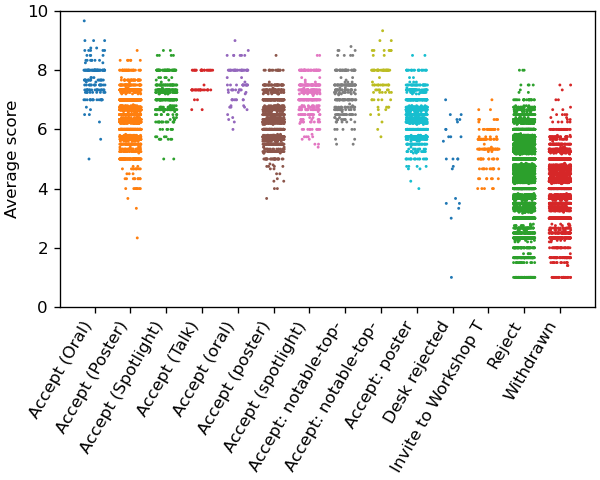

In [9]:
# Sanity check

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')

avScores = np.array([np.mean(sc) for sc in iclr.scores])

np.random.seed(42)
for num, decision in enumerate(np.unique(iclr.decision)):
    mask = iclr.decision == decision
    ax.scatter(np.random.uniform(num-.3, num+.3, size=np.sum(mask)), avScores[mask], s=3, ec='none')

ax.set_ylim([0,10])
ax.set_ylabel('Average score')
ax.set_xticks(np.arange(np.unique(iclr.decision).size), 
              [d[:20] for d in np.unique(iclr.decision)], rotation=60, ha='right');

<IPython.core.display.Javascript object>


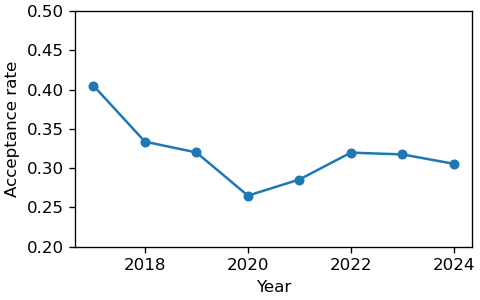

In [10]:
# Sanity check

years = np.arange(2017, 2025)

accept_rate = [np.mean([d[:3]=='Acc' for d in iclr[iclr.year==y].decision]) for y in years]

plt.figure(figsize=(4, 2.5), layout='constrained')
plt.plot(years, accept_rate, '.-', markersize=10)
plt.xlabel('Year')
plt.ylabel('Acceptance rate')
plt.ylim([0.2, 0.5]);

In [11]:
# Sanity check: top-scored papers

iclr[avScores >= 9]

,year,id,title,abstract,authors,decision,scores,keywords
348,2017,Sy8gdB9xx,Understanding deep learning requires rethinkin...,"Despite their massive size, successful deep ar...","Chiyuan Zhang, Samy Bengio, Moritz Hardt, Benj...",Accept (Oral),"[10, 10, 9]",[deep learning]
381,2017,r1Ue8Hcxg,Neural Architecture Search with Reinforcement ...,Neural networks are powerful and flexible mode...,"Barret Zoph, Quoc Le",Accept (Oral),"[9, 9, 9]",[]
862,2018,Hk6kPgZA-,Certifying Some Distributional Robustness with...,Neural networks are vulnerable to adversarial ...,"Aman Sinha, Hongseok Namkoong, John Duchi",Accept (Oral),"[9, 9, 9]","[adversarial training, distributionally robust..."
10763,2022,b-ny3x071E5,Bootstrapped Meta-Learning,Meta-learning empowers artificial intelligence...,"Sebastian Flennerhag, Yannick Schroecker, Tom ...",Accept (Oral),"[10, 8, 10, 8]","[meta-learning, meta-gradients, meta-reinforce..."
12842,2023,88nT0j5jAn,Universal Few-shot Learning of Dense Predictio...,Dense prediction tasks are a fundamental class...,"Donggyun Kim, Jinwoo Kim, Seongwoong Cho, Chon...",Accept: notable-top-5%,"[10, 8, 10]","[few-shot learning, dense prediction tasks]"
14562,2023,Uuf2q9TfXGA,"Towards Understanding Ensemble, Knowledge Dist...",We formally study how \emph{ensemble} of deep ...,"Zeyuan Allen-Zhu, Yuanzhi Li",Accept: notable-top-5%,"[8, 10, 10, 8]",[]
15942,2023,lTt4KjHSsyl,Emergence of Maps in the Memories of Blind Nav...,Animal navigation research posits that organis...,"Erik Wijmans, Manolis Savva, Irfan Essa, Stefa...",Accept: notable-top-5%,"[10, 10, 8, 8]","[embodied ai, navigation, characterizing repre..."
21327,2024,aN4Jf6Cx69,The mechanistic basis of data dependence and a...,Transformer models exhibit in-context learning...,Gautam Reddy,Accept (oral),"[10, 10, 8, 8]","[in-context learning, mechanistic interpretabi..."


In [12]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords
0,2017,B1-Hhnslg,Prototypical Networks for Few-shot Learning,A recent approach to few-shot classification c...,"Jake Snell, Kevin Swersky, Richard Zemel",Reject,"[6, 4, 5]","[deep learning, transfer learning]"
1,2017,B1-q5Pqxl,Machine Comprehension Using Match-LSTM and Ans...,Machine comprehension of text is an important ...,"Shuohang Wang, Jing Jiang",Accept (Poster),"[6, 6, 7]","[natural language processing, deep learning]"
2,2017,B16Jem9xe,Learning in Implicit Generative Models,Generative adversarial networks (GANs) provide...,"Shakir Mohamed, Balaji Lakshminarayanan",Invite to Workshop Track,"[8, 7, 6]",[unsupervised learning]
3,2017,B16dGcqlx,Third Person Imitation Learning,Reinforcement learning (RL) makes it possible ...,"Bradly C Stadie, Pieter Abbeel, Ilya Sutskever",Accept (Poster),"[6, 5, 6]",[]
4,2017,B184E5qee,Improving Neural Language Models with a Contin...,We propose an extension to neural network lang...,"Edouard Grave, Armand Joulin, Nicolas Usunier",Accept (Poster),"[7, 9, 5]",[natural language processing]
...,...,...,...,...,...,...,...,...
24440,2024,zxPDdw8koz,CLIP meets Model Zoo Experts: Pseudo-Supervisi...,Contrastive language image pretraining (CLIP) ...,"Mohammadreza Salehi, Mehrdad Farajtabar, Maxwe...",Withdrawn,"[8, 3, 3, 3]","[contrastive learning, clip, distillation, den..."
24441,2024,zyBJodMrn5,On the generalization capacity of neural netwo...,The advent of the Transformer has led to the d...,"Takuya Ito, Soham Dan, Mattia Rigotti, James K...",Accept (poster),"[8, 3, 6]","[compositional generalization, compositionalit..."
24442,2024,zz61V8bIab,Stochastic Adversarial Networks for Multi-Doma...,Adversarial training has played a pivotal role...,"Xu Wang, Yuan Wu",Withdrawn,"[5, 1, 5]","[multi-domain text classification, adversarial..."
24443,2024,zzqn5G9fjn,Breaking Physical and Linguistic Borders: Mult...,Pretrained large language models (LLMs) have e...,"Wanru Zhao, Royson Lee, Yihong Chen, Xinchi Qi...",Accept (poster),"[5, 3, 1, 8]","[multilingual federated learning, natural lang..."
